In [1]:
# Check Pytorch installation
import cv2
import os
import json
import roboflow
import random

import numpy as np

from mmdet.apis import init_detector, inference_detector

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Check MMDetection installation
from mmengine.utils import get_git_hash
from mmengine.utils.dl_utils import collect_env as collect_base_env

import mmdet

print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

import os
HOME = os.getcwd()
print("HOME:", HOME)
torch.cuda.current_device()
torch.cuda.set_device(2)
torch.cuda.current_device()

2.0.0+cu117 True
3.3.0
11.7
GCC 9.3
HOME: /work/van-speech-nlp/jindaznb/j-vis



    Found GPU0 Tesla K40m which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    


RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="a8fzziqukkQgsmGFnKgD")
project = rf.workspace("wildfire2024").project("forestfire2024")
dataset = project.version(1).download("coco-mmdetection")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to wildfire2024-5 in coco-mmdetection:: 100%|██████████| 643/643 [00:08<00:00, 77.57it/s] 

{'Alive Tree': 64694, 'Dead Tree': 7274, 'Beetle-Fire Tree': 4103, 'Debris': 4603}


In [5]:
CUSTOM_WEIGHTS_PATH = f"{HOME}/mmyolo/work_dirs/custom-rtmdet-m/epoch_200.pth"
CUSTOM_CONFIG_PATH = f"{HOME}/mmyolo/configs/rtmdet/custom-rtmdet-m.py"
model = init_detector(CUSTOM_CONFIG_PATH, CUSTOM_WEIGHTS_PATH, device=DEVICE)

Loads checkpoint by local backend from path: /work/van-speech-nlp/jindaznb/j-vis/mmyolo/work_dirs/custom-rtmdet-m/epoch_620.pth


In [6]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

images = list(ds.images.values())
# images

In [13]:
# # Choose a random image from the list of images
# image = random.choice(images)

# # Perform object detection using the model on the selected image
# result = inference_detector(model, image)

# # Convert the detection results to a custom format using a utility function
# detections = sv.Detections.from_mmdetection(result)

# # Filter out detections with confidence less than 0.4 and apply Non-Maximum Suppression (NMS)
# detections = detections[detections.confidence > 0.4].with_nms()
# for i in detections:
#     print(i)

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)


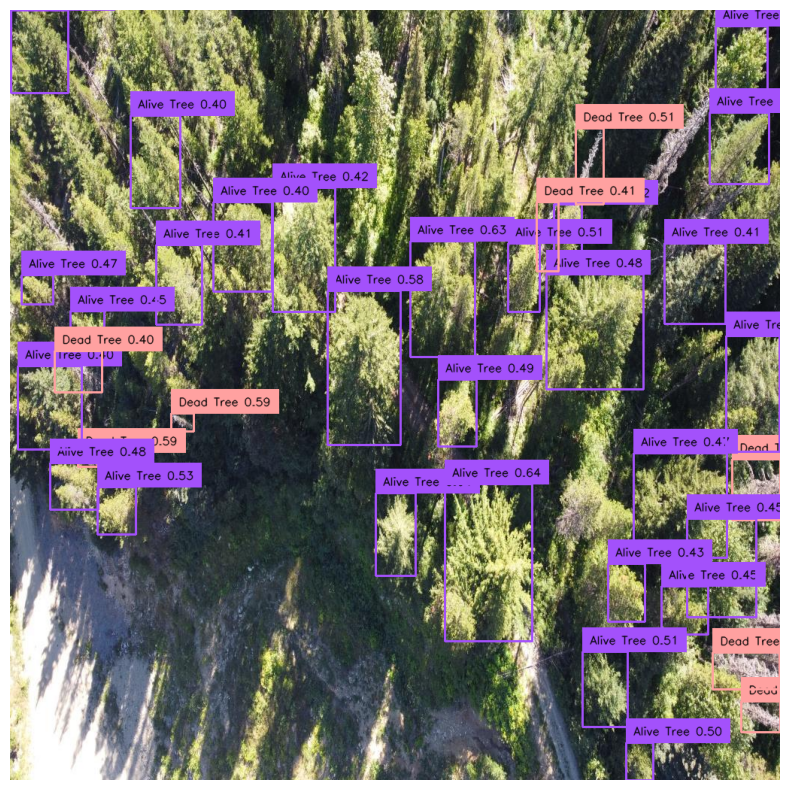

In [8]:
# # Choose a random image from the list of images
# image = random.choice(images)

# # Perform object detection using the model on the selected image
# result = inference_detector(model, image)

# # Convert the detection results to a custom format using a utility function
# detections = sv.Detections.from_mmdetection(result)

# # Filter out detections with confidence less than 0.4 and apply Non-Maximum Suppression (NMS)
# detections = detections[detections.confidence > 0.4].with_nms()

# # Create a box annotator object to draw bounding boxes on the image
# box_annotator = sv.BoxAnnotator()

# # Generate labels for each detection, including class name and confidence
# labels = [
#     f"{ds.classes[class_id]} {confidence:0.2f}"
#     for _, _, confidence, class_id, _,_
#     in detections
# ]

# # Create an annotated image with bounding boxes and labels
# annotated_image = box_annotator.annotate(image.copy(), detections, labels=labels)

# # Plot the annotated image using the plot_image function from the sv library
# sv.plot_image(image=annotated_image, size=(10, 10))

In [17]:
# ds = sv.DetectionDataset.from_coco(
#     images_directory_path=f"{dataset.location}/test",
#     annotations_path=f"{dataset.location}/test/_annotations.coco.json",
# )

# print('dataset classes:', ds.classes)
# print('dataset size:', len(ds))

In [15]:
# def callback(image: np.ndarray) -> sv.Detections:
#     result = inference_detector(model, image)
#     detections = sv.Detections.from_mmdetection(result)
#     return detections[detections.confidence > CONFIDENCE_THRESHOLD].with_nms(threshold=NMS_IOU_THRESHOLD)


# confusion_matrix = sv.ConfusionMatrix.benchmark(
#     dataset = ds,
#     callback = callback,
#     # iou_threshold=0.2
# )

# _ = confusion_matrix.plot()
# confusion_matrix

In [18]:
import numpy as np

# Load the dataset
ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

# Define the search space for hyperparameters
param_space = {
    'CONFIDENCE_THRESHOLD': np.linspace(0.1, 1.0, 20),  # Adjust the range as needed
    'NMS_IOU_THRESHOLD': np.linspace(0.1, 1.0, 20),  # Adjust the range as needed
}

best_map = 0.0
best_params = {}

# Perform random search
for _ in range(20):  # You can adjust the number of random samples
    CONFIDENCE_THRESHOLD= np.random.choice(param_space['CONFIDENCE_THRESHOLD'])
    # NMS_IOU_THRESHOLD= np.random.choice(param_space['NMS_IOU_THRESHOLD'])
    
    def callback(image: np.ndarray) -> sv.Detections:
        result = inference_detector(model, image)
        detections = sv.Detections.from_mmdetection(result)
        return detections[detections.confidence > CONFIDENCE_THRESHOLD].with_nms(threshold=0.5)

    mean_average_precision = sv.MeanAveragePrecision.benchmark(dataset=ds, callback=callback)

    if mean_average_precision.map50_95 > best_map:
        best_map = mean_average_precision.map50_95
        best_params = [CONFIDENCE_THRESHOLD,NMS_IOU_THRESHOLD]

print('Best mAP:', best_map)
print('Best Parameters:', best_params)

Best mAP: 0.33895730230031607
Best Parameters: [0.5736842105263158, 0.6210526315789474]
